# Задание 2

In [1]:
import pandas as pd
import nltk
import spacy
from nltk.tokenize import PunktSentenceTokenizer, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import warnings
import re
from gensim import corpora, models, similarities
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

# nltk.download('punkt')
#nltk.download('stopwords')

warnings.filterwarnings("ignore")

In [2]:
class BbcDataset(object):
    def __init__(self):
        self.DATA_DIR = "bbc/"
        self.classes = os.listdir(self.DATA_DIR)
        self.n_documents = len([os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files])

    def get_dataset(self):
        data = []
        for file in [os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files]:
            label = file.split("/")[-2]
            content = " ".join(open(file, encoding='utf-8', errors='ignore').read().splitlines())
            data.append((content, label))
        return data

    def get_pandas_alike_dataset(self):
        data = self.get_dataset()
        return pd.DataFrame(data, columns=["text", "label"])

In [3]:
df = BbcDataset().get_pandas_alike_dataset()
df = df[df.label != "bbc"]
df['label'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

In [8]:
class DataPreproces(object):
    def __init__(self, df, df_text):
        self.df = df
        self.df_text = df_text
        self.regex = re.compile("[A-Za-z]+")
        self.mystopwords = stopwords.words('english') 
        self.additional_stop_words = ['say','go','come','get','see','use','take','want','tell','need','also','people','year','good','include']

    def words_only(self, text):
        return " ".join(self.regex.findall(text))

    def remove_stopwords(self, text):
        try:
            return " ".join([token for token in text.split() if not token in self.mystopwords])
        except:
            return ""

    def parse_filter_document(self, text):
        filtered_doc = []
        for token in text:
            if token.is_stop == False | token.is_punct == False | token.is_space == False:
                if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
                    if token.lemma_ not in self.additional_stop_words:
                        filtered_doc.append(token.lemma_)

        return ' '.join(filtered_doc)
    
    def final_dataset(self):
        self.df_text = self.df_text.str.lower()
        self.df_text = self.df_text.apply(self.words_only)
        self.df_text = self.df_text.apply(self.remove_stopwords)
        
        nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
        
        self.df['processed_text'] = self.df_text.apply(lambda x: self.parse_filter_document(nlp(x)))
        
        data = self.df[['processed_text','label']]
        
        return data
        

In [9]:
data = DataPreproces(df, df.text).final_dataset()
data

,processed_text,label
1,musician tackle red tape musician group tackle...,entertainment
2,desire number prestigious award hit vertigo st...,entertainment
3,rocker doherty stage fight rock singer pete do...,entertainment
4,snicket top chart film lemony snicket novel to...,entertainment
5,ocean crime caper sequel star straight number ...,entertainment
...,...,...
2221,warn window word file write word document dang...,tech
2222,fast lift rise record book high speed lift wor...,tech
2223,add medium playing nintendo release handheld c...,tech
2224,fast move phone virus appear security firm war...,tech


In [94]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

class Topics(object):
    def __init__(self, data, class_name):
        self.data = data
        self.class_name = class_name
    
    def dictionary_corpus(self, df):
        texts = [df.processed_text.iloc[i].split() for i in range(len(df))]
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]
        return dictionary, corpus

    def lda(self):
        print(f"Topics for class '{self.class_name}': \n")
        
        df_name = self.data[self.data.label == self.class_name]

        dictionary, corpus = self.dictionary_corpus(df_name)
            
        topic_list = []
        word_list = []

        lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=dictionary,
                                             num_topics=4,
                                             random_state=100,
                                             update_every=1,
                                             chunksize=100,
                                             passes=10,
                                             alpha='auto',
                                             per_word_topics=True)

        words = lda_model.show_topics(formatted=False)
        
        for i in range(len(words)):
            one_topic_list = []
            for j in range(len(words[0][1])):
                one_topic_list.append(words[i][1][j][0])
            print(f"Topic {words[i][0]} words list:")
            print(", ".join(one_topic_list), "\n")
            
        
        return lda_model, corpus, dictionary, words
    

In [95]:
def cloud_vis(words):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
    mystopwords = stopwords.words('english') 
    
    cloud = WordCloud(stopwords=mystopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    fig, axes = plt.subplots(1,4 , figsize=(20,20), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(words[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic: ' + str(words[i][0]), fontdict=dict(size=16))
        plt.gca().axis('off')

## Class Business

In [110]:
lda_business, cor_business, dic_business, words_business = Topics(data, 'business').lda()

vis_business = gensimvis.prepare(lda_business, cor_business, dic_business)
pyLDAvis.display(vis_business)

Topics for class 'business': 

Topic 0 words list:
rate, economy, job, growth, economic, rise, fall, country, low, interest 

Topic 1 words list:
sale, market, rise, price, company, profit, high, firm, production, oil 

Topic 2 words list:
company, fraud, government, report, firm, claim, state, case, credit, total 

Topic 3 words list:
firm, deal, business, company, buy, new, stake, list, share, fiat 



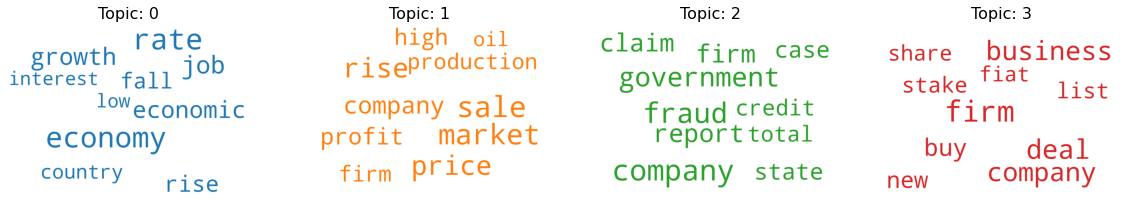

In [97]:
cloud_vis(words_business)

### Вывод 

Из визуализаций видно, что в классе Business больше всего говорится о: 
- экономике (о ее росте, падении, об экономике стран) 
- деятельности компаний (рынках сбыта, ценах, продажах с торгов, прибылях)
- деятельности правительства, кредитах
- негативных факторах, например, исках, претензиях, мошенничестве
- о ведении бизнеса (новых сделках, передаче бизнеса, доле капитала, санкциях)

## Class Entertainment

In [99]:
lda_entert, cor_entert, dic_entert, words_entert = Topics(data, 'entertainment').lda()

vis_entert = gensimvis.prepare(lda_entert, cor_entert, dic_entert)
pyLDAvis.display(vis_entert)

Topics for class 'entertainment': 

Topic 0 words list:
film, award, actor, oscar, director, win, nomination, actress, winner, category 

Topic 1 words list:
song, band, album, singer, music, single, number, record, pop, tv 

Topic 2 words list:
film, star, movie, new, book, play, man, director, work, screen 

Topic 3 words list:
music, band, song, album, chart, sale, think, number, single, time 



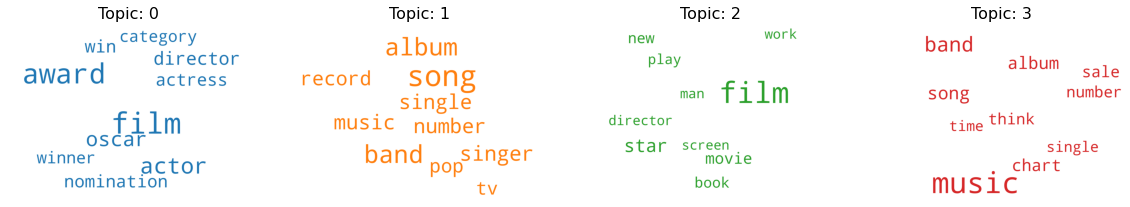

In [100]:
cloud_vis(words_entert)

### Вывод

Из визуализаций видно, что в классе Entertainment больше всего говорится о: 
- кинематографе (фильмах, наградах, режиссерах, актерах, победителях номинаций, премии Оскар)
- музыке (песнях, новых альбомах и записях, певцах, группах, чартах)

## Class Politics

In [101]:
lda_pol, cor_pol, dic_pol, words_pol = Topics(data, 'politics').lda()

vis_pol = gensimvis.prepare(lda_pol, cor_pol, dic_pol)
pyLDAvis.display(vis_pol)

Topics for class 'politics': 

Topic 0 words list:
government, plan, tax, increase, cut, public, labour, work, service, pay 

Topic 1 words list:
election, party, labour, tory, claim, vote, issue, leader, general, government 

Topic 2 words list:
wale, change, law, child, court, work, issue, new, police, health 

Topic 3 words list:
government, terrorist, right, threat, new, law, police, agree, human, trial 



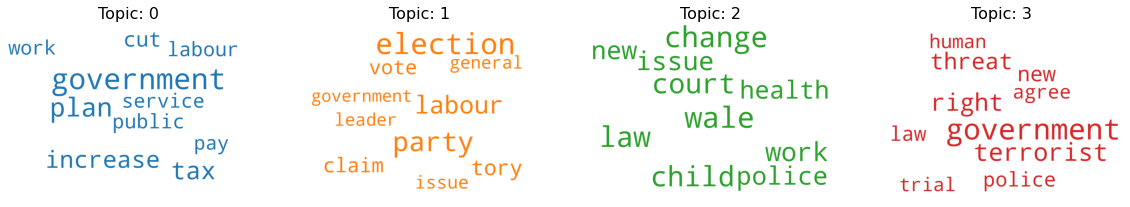

In [102]:
cloud_vis(words_pol)

### Вывод

Из визуализаций видно, что в классе Politics больше всего говорится о: 
- деятельности правительства (операциях с налогами, законопроектах)
- выборах (голосовании) в правительство, различные партии 
- изменениях в части законов, суда, здравоохранения, детей, труда

## Class Sport

In [104]:
lda_sport, cor_sport, dic_sport, words_sport = Topics(data, 'sport').lda()

vis_sport = gensimvis.prepare(lda_sport, cor_sport, dic_sport)
pyLDAvis.display(vis_sport)

Topics for class 'sport': 

Topic 0 words list:
test, miss, ban, drug, game, charge, appeal, sprinter, greek, decision 

Topic 1 words list:
game, player, play, club, time, team, manager, think, look, add 

Topic 2 words list:
win, final, play, set, world, open, time, beat, match, run 

Topic 3 words list:
half, game, try, play, win, second, wale, nation, goal, penalty 



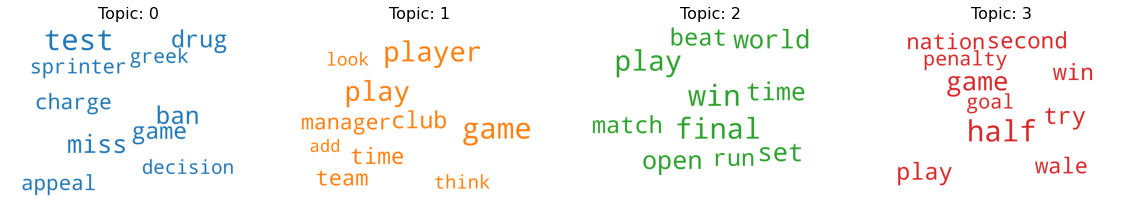

In [105]:
cloud_vis(words_sport)

### Вывод


Из визуализаций видно, что в классе Sport больше всего говорится о: 
- негативных ситуациях в спорте  (дисквалификациях, допингах, аппеляциях, пропусках)
- командах (участвующие команды, игроки, менеджеры, времени в играх)
- процессе и результатах матчей (кто выиграл, прошел в финал, времени игры, пенальти, счете, голах)

## Class Tech

In [106]:
lda_tech, cor_tech, dic_tech, words_tech = Topics(data, 'tech').lda()

vis_tech = gensimvis.prepare(lda_tech, cor_tech, dic_tech)
pyLDAvis.display(vis_tech)

Topics for class 'tech': 

Topic 0 words list:
music, file, itune, song, apple, p, peer, legal, download, firm 

Topic 1 words list:
game, mobile, technology, player, new, digital, time, video, device, phone 

Topic 2 words list:
user, itune, security, version, problem, file, program, firm, update, threat 

Topic 3 words list:
service, net, site, user, phone, search, internet, mail, information, network 



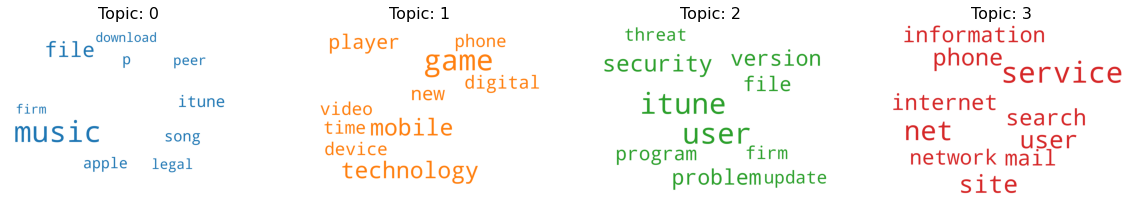

In [107]:
cloud_vis(words_tech)

### Вывод

Из визуализаций видно, что в классе Tech больше всего говорится о: 
- скачивании файлов и музыки, использовании техниики Apple и iTunes
- девайсах и мобильных устройствах (их использовании, просмотре видео, об играх на них)
- информационных системах (ПО, файлах, пользователях, версиях, безопасности, обновлениях, проблемах)
- темах, связаных с интернетом